# W7 Homework Assignment 6
### Naïve Bayes and Decision Tree for handwriting recognition
Syracuse Applied Data Science, IST-707 Data Analytics  

Ryan Timbrook (RTIMBROO)  
DATE: 8/20/2019
ASSIGNMENT: Homework 6


## 1. Introduction
**-------------------------------------------------------------------------------------------------**  
Recognize digits 0 to 9 in handwriting images. Use the sampled data to construct prediction models using naive Bayes and decision tree algorithms, additionally tune their parameters to get the best model (measured by cross validation) and compare which algorithms provide better model for this task. The success metric is evaluated on the categorization accuracy of the predictions ( the percentage of images predicted correctly).

### 1.1 About the Data  
**-------------------------------------------------------------------------------------------------**  
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.  

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.  
Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.  

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:  
000 001 002 003 ... 026 027  
028 029 030 031 ... 054 055  
056 057 058 059 ... 082 083  
 |   |   |   |  ...  |   |  
728 729 730 731 ... 754 755  
756 757 758 759 ... 782 783   
The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.  





#### Dataset Info  
**Training Dataset Shape**  
* Row Count:
* Column Count:  
**Testing Dataset Shape**  
* Row Count:
* Column Count:  


### --------------------------------------------------------------------------------------------
# Coding Environment Setup
Import packages

#### Package pymc
PyMC is a python module that implements Bayesian statistical models and fitting algorithms. Its flexibility and extensibility make it applicable to a large suite of problems. Along with core sampling functionality, PyMC includes methods for summarizing output, plotting, goodness-of-fit and convergence diagnostics.  

Find documenation [here](https://pymc-devs.github.io/pymc/)

#### Package scipy
SciPy is a Python-based ecosystem of open-source software for mathematics, science, and engineering.  

In [1]:
# import packages
import pandas as pd                            # data frame operations
import numpy as np                             # arrays and match functions

import seaborn as sns                          # uses for visualizations
import matplotlib.pyplot as plt                # used for 2D plotting
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework


In [2]:
# custome python packages
import rtimbroo_ist_utils as rt                # custome python helper functions

In [3]:
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#from mpl_toolkits.mplot3d import Axes3D


In [1]:
# set global environment properties
dataDir = './data/'
outputDir = './output/'
configDir = './config/'
logOutDir = './log/'
imageDir = './images/'
modelDir = './models/'
#modelImprovedDir = './models/improved/'
#loggerConfig = 'loggerConfig.yaml'
loglevel = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

In [5]:
# get loggers
warnings.filterwarnings('ignore')
sh_logger = rt.getSHLogger(name='stream_handler',level=loglevel)

## 1.3 Obtain the data  
Read in the data sets  
FileNames: 
* Kaggle-digit-train-sample-small-1400.csv---# is a subset of original Kaggel training set  
* Kaggle-digit-test-sample1000.csv-----------# is a subset of original Kaggel test set  
* Kaggle-digit-train.csv---------------------# is the full Kaggel training set  
* Kaggle-digit-test.csv----------------------# is the full Kaggel test set  


In [6]:
%%time
# file names
trainSampleFile = 'Kaggle-digit-train-sample-small-1400.csv'
testSampleFile = 'Kaggle-digit-test-sample1000.csv'
trainFullFile = 'Kaggle-digit-train.csv'
testFullFile = 'Kaggle-digit-test.csv'
sampleSubmissionFile = 'sample_submission.csv'

train_sample = pd.read_csv(f'{dataDir}{trainSampleFile}')
test_sample = pd.read_csv(f'{dataDir}{testSampleFile}')
train_full = pd.read_csv(f'{dataDir}{trainFullFile}')
test_full = pd.read_csv(f'{dataDir}{testFullFile}')
sample_sub = pd.read_csv(f'{dataDir}{sampleSubmissionFile}')


Wall time: 4.64 s


In [7]:
# look at the shape of the data
if sh_logger.info: print(f'Kaggel Sample Train data set shape: [{train_sample.shape}]')
if sh_logger.info: print(f'Kaggel Sample Test data set shape: [{test_sample.shape}]')
if sh_logger.info: print(f'Kaggel Full Train set shape: [{train_full.shape}]')
if sh_logger.info: print(f'Kaggel Full Test set shape: [{test_full.shape}]')

Kaggel Sample Train data set shape: [(1400, 785)]
Kaggel Sample Test data set shape: [(1000, 785)]
Kaggel Full Train set shape: [(42000, 785)]
Kaggel Full Test set shape: [(28000, 785)]


In [8]:
test_sample.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [9]:
# look for NaN fields in the sample dataset
if sh_logger.debug: print(f'Sample Train data set columns NANs: {rt.getColumnsNaNCnts(train_sample)}')
#if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.getColumnsNaNCnts(test_sample.drop(columns="label"))}')
if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.findColumnsNaN(test_sample.drop(columns="label"))}')
                    

Sample Train data set columns NANs: 0
Column: pixel0 has: 1 NaN values
pixel0: [999]

Column: pixel1 has: 1 NaN values
pixel1: [999]

Column: pixel2 has: 1 NaN values
pixel2: [999]

Column: pixel3 has: 1 NaN values
pixel3: [999]

Column: pixel4 has: 1 NaN values
pixel4: [999]

Column: pixel5 has: 1 NaN values
pixel5: [999]

Column: pixel6 has: 1 NaN values
pixel6: [999]

Column: pixel7 has: 1 NaN values
pixel7: [999]

Column: pixel8 has: 1 NaN values
pixel8: [999]

Column: pixel9 has: 1 NaN values
pixel9: [999]

Column: pixel10 has: 1 NaN values
pixel10: [999]

Column: pixel11 has: 1 NaN values
pixel11: [999]

Column: pixel12 has: 1 NaN values
pixel12: [999]

Column: pixel13 has: 1 NaN values
pixel13: [999]

Column: pixel14 has: 1 NaN values
pixel14: [999]

Column: pixel15 has: 1 NaN values
pixel15: [999]

Column: pixel16 has: 1 NaN values
pixel16: [999]

Column: pixel17 has: 1 NaN values
pixel17: [999]

Column: pixel18 has: 1 NaN values
pixel18: [999]

Column: pixel19 has: 1 NaN value


Column: pixel264 has: 1 NaN values
pixel264: [999]

Column: pixel265 has: 1 NaN values
pixel265: [999]

Column: pixel266 has: 1 NaN values
pixel266: [999]

Column: pixel267 has: 1 NaN values
pixel267: [999]

Column: pixel268 has: 1 NaN values
pixel268: [999]

Column: pixel269 has: 1 NaN values
pixel269: [999]

Column: pixel270 has: 1 NaN values
pixel270: [999]

Column: pixel271 has: 1 NaN values
pixel271: [999]

Column: pixel272 has: 1 NaN values
pixel272: [999]

Column: pixel273 has: 1 NaN values
pixel273: [999]

Column: pixel274 has: 1 NaN values
pixel274: [999]

Column: pixel275 has: 1 NaN values
pixel275: [999]

Column: pixel276 has: 1 NaN values
pixel276: [999]

Column: pixel277 has: 1 NaN values
pixel277: [999]

Column: pixel278 has: 1 NaN values
pixel278: [999]

Column: pixel279 has: 1 NaN values
pixel279: [999]

Column: pixel280 has: 1 NaN values
pixel280: [999]

Column: pixel281 has: 1 NaN values
pixel281: [999]

Column: pixel282 has: 1 NaN values
pixel282: [999]

Column: pix

Column: pixel545 has: 1 NaN values
pixel545: [999]

Column: pixel546 has: 1 NaN values
pixel546: [999]

Column: pixel547 has: 1 NaN values
pixel547: [999]

Column: pixel548 has: 1 NaN values
pixel548: [999]

Column: pixel549 has: 1 NaN values
pixel549: [999]

Column: pixel550 has: 1 NaN values
pixel550: [999]

Column: pixel551 has: 1 NaN values
pixel551: [999]

Column: pixel552 has: 1 NaN values
pixel552: [999]

Column: pixel553 has: 1 NaN values
pixel553: [999]

Column: pixel554 has: 1 NaN values
pixel554: [999]

Column: pixel555 has: 1 NaN values
pixel555: [999]

Column: pixel556 has: 1 NaN values
pixel556: [999]

Column: pixel557 has: 1 NaN values
pixel557: [999]

Column: pixel558 has: 1 NaN values
pixel558: [999]

Column: pixel559 has: 1 NaN values
pixel559: [999]

Column: pixel560 has: 1 NaN values
pixel560: [999]

Column: pixel561 has: 1 NaN values
pixel561: [999]

Column: pixel562 has: 1 NaN values
pixel562: [999]

Column: pixel563 has: 1 NaN values
pixel563: [999]

Column: pixe

In [10]:
# look for NaN fields in the full dataset
if sh_logger.debug: print(f'Full Train data set columns NANs: {rt.getColumnsNaNCnts(train_full)}')
#if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.getColumnsNaNCnts(test_sample.drop(columns="label"))}')
if sh_logger.debug: print(f'Full Test data set columns NANs: {rt.findColumnsNaN(test_full.drop(columns="label"))}')
         

Full Train data set columns NANs: 0
Full Test data set columns NANs: None


In [11]:
# observation 999 of the test_sample set has all NaN values - remove this observation
test_sample.iloc[999,].isna()

label       False
pixel0       True
pixel1       True
pixel2       True
pixel3       True
            ...  
pixel779     True
pixel780     True
pixel781     True
pixel782     True
pixel783     True
Name: 999, Length: 785, dtype: bool

In [12]:
test_sample = test_sample.drop(index=999)
if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.findColumnsNaN(test_sample.drop(columns="label"))}')

Sample Test data set columns NANs: None


In [13]:
if sh_logger.info: print(f'Full Training Dataset Info:')
if sh_logger.info: print(f'{train_full.info()}\n')
if sh_logger.info: print(f'Full Testing Dataset Info:')
if sh_logger.info: print(f'{test_full.info()}\n')                         


Full Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None

Full Testing Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 785 entries, label to pixel783
dtypes: int64(784), object(1)
memory usage: 167.7+ MB
None



In [14]:
# convert labels to categorical datatype
label_values = train_full['label'].unique()
label_values.sort()
if sh_logger.debug: print(f'Training Label Values: {label_values}')

Training Label Values: [0 1 2 3 4 5 6 7 8 9]


In [15]:
train_full['label'] = train_full['label'].astype('category')
train_full['label']

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: category
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

### Create Training and Test Splits
Using the full data set, create training and test splits   

In [16]:
# separate the dataset into X y - y is the classificier (response variable),
X = np.asarray(train_full.drop(columns='label'))
y = np.asarray(train_full['label'])

# this is for the kaggel submission test set submission
X_sub = np.asarray(test_full.drop(columns='label'))


In [17]:
# reduce memory consumption - max value of a given attribute is an int of 783
X = X.astype(np.int32) # 
y = y.astype(np.int32) #
X_sub = X_sub.astype(np.int32) #

# create training test splits
# hold out part of the available data as a test set X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

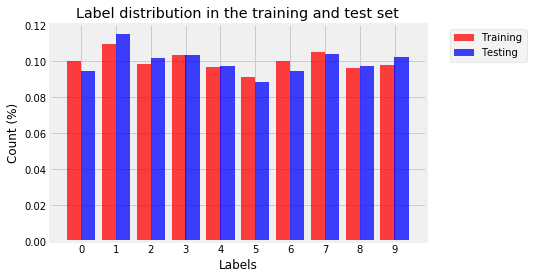

In [18]:
# number of label classes, 0 - 9
n_classes = 10

# look for imbalance in the sample observations for the class
training_counts = [None] * n_classes
testing_counts = [None] * n_classes

for i in range(n_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)

# plot histogram of the data
train_bar = plt.bar(np.arange(n_classes)-0.2, training_counts, align='center', color = 'r', alpha=0.75, width = 0.41, label='Training')
test_bar = plt.bar(np.arange(n_classes)+0.2, testing_counts, align='center', color = 'b', alpha=0.75, width = 0.41, label = 'Testing')

plt.xlabel('Labels')
plt.xticks((0,1,2,3,4,5,6,7,8,9))
plt.ylabel('Count (%)')
plt.title('Label distribution in the training and test set')
plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar], loc=2)
plt.grid(True)
plt.show()



# 2. Decision Tree
**-------------------------------------------------------------------------------------------------**  
*Build a decision tree model. Tune the parameters, such as the pruning options, and report the 3-fold CV accuracy.*  

## 2.1 Data Analysis
Clean and perform initial transformations steps of the data

### 2.1.1 Data Preprocessing (Scrubbing & Cleaning)

In [19]:
# perform scrubbing and cleaning techniques

modelsPerformance = {'Name':[], 'TestAccuracyScore':[],'PredictAccuracyScore':[] ,'FitTime':[], 'ScoreTime':[], 'PredictTime':[]}

# create copy of training data to work on for model tuning with Cross-Validation
data = np.copy(X)
target = np.copy(y)

### 2.1.2 Explore
Explore the datasets

In [20]:
# perform exploratory data analysis techiques

#### Modeling & Evaluation Functions

In [21]:
# function used for clocking processing time to build/run models
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start

Python package [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)  

In [22]:
# Confusion matrix 
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 2.2 Model - DecisionTreeClassifier
Python package: [scikit-learn sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  


### 2.2.1 Create Base Model
no cross validation techniques applied...

In [23]:
dtc = DecisionTreeClassifier(random_state=0)
t = 0.0
with elapsed_timer() as elapsed:
    # fit the forest to the training data
    dtc.fit(X_train, y_train)
    t = elapsed()
    if sh_logger.debug: print(f'DecisionTreeClassifier Model Build Time: [{t}]')

modelsPerformance['Name'].append('dtc')
modelsPerformance['FitTime'].append(t)

DecisionTreeClassifier Model Build Time: [10.152260599999998]


In [24]:
# Model Output to kaggel training dataset split into training/testing
# no cross-validation applied
t = 0.0
with elapsed_timer() as elapsed:
    dtc_score =  dtc.score(X_test, y_test)
    t = elapsed()
    if sh_logger.info: print(f'DecisionTreeClassifier Model Fit Score: {[dtc_score]}')
    if sh_logger.debug: print(f'DecisionTreeClassifier Model Fit Score Time: [{t}]')

modelsPerformance['TestAccuracyScore'].append(dtc_score)
modelsPerformance['ScoreTime'].append(elapsed())

DecisionTreeClassifier Model Fit Score: [0.8448051948051948]
DecisionTreeClassifier Model Fit Score Time: [0.07558389999999804]


### 2.2.1.1 Fit Model Prediciton - DecisionTreeClassifier

In [25]:
#%%time
# predictions of test set split from training set
t = 0.0
with elapsed_timer() as elapsed:
    dtc_pred = dtc.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'DecisionTreeClassifier Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

DecisionTreeClassifier Predict Time: [0.061106299999998726]


In [53]:
%%time
if sh_logger.debug: print(f'y_test size: {y_test.size} dtc_pred size: {dtc_pred.size}')

d = {'Label':y_test, 'Prediction':dtc_pred}
treePredictionsDf = pd.DataFrame(data=d)
if sh_logger.debug: print(f'Decision Tree Predictions DF Shape: {treePredictionsDf.shape}\n Head:\n{treePredictionsDf.head()}')

# which test observations were miss classified
missClassified_DT = treePredictionsDf[(treePredictionsDf['Label'] != treePredictionsDf['Prediction'])]

if sh_logger.debug: print(f'Miss Classified DF Shape: {missClassified_DT.shape}')
if sh_logger.debug: print(f'Miss Classified Percent: {missClassified_DT.shape[0]/y_test.size}')
if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != dtc_pred).sum()}]')

y_test size: 13860 dtc_pred size: 13860
Decision Tree Predictions DF Shape: (13860, 2)
 Head:
   Label  Prediction
0      7           2
1      4           4
2      5           5
3      5           5
4      1           1
Miss Classified DF Shape: (2151, 2)
Miss Classified Percent: 0.1551948051948052
Total Number of points: [13860]  Mislabeled Points: [2151]
Wall time: 3.99 ms


### 2.2.1.2 Evaluate Model

Total Number of points: [13860]  Mislabeled Points: [2151]
Percent Mislabeled: [0.1551948051948052]
Percent Accurately Labeled: [0.8448051948051948]


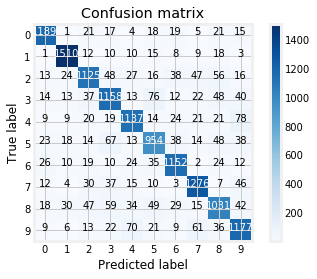

In [27]:
misLabeled = (y_test != dtc_pred).sum()/X_test.shape[0]
dtcAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != dtc_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_test != dtc_pred).sum()/X_test.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{dtcAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(dtcAccuractelyLabeled)

# confusion matrix evaluation
cm = confusion_matrix(y_test,dtc_pred, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

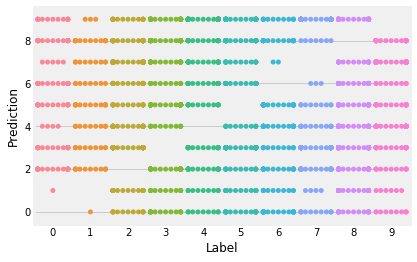

In [54]:
sns.swarmplot(x='Label',y='Prediction',data=missClassified_DT);

In [28]:
#from sklearn import tree
#tree.plot_tree(dtc.fit(X_train, y_train))
modelsPerformance

{'Name': ['dtc'],
 'TestAccuracyScore': [0.8448051948051948],
 'PredictAccuracyScore': [0.8448051948051948],
 'FitTime': [10.152260599999998],
 'ScoreTime': [0.07575149999999553],
 'PredictTime': [0.061106299999998726]}

### 2.2.2 Create Model with CV
Python Package: [SciKit-Learn model_selection cross_validate](https://scikit-learn.org/stable/modules/cross_validation.html)   
See also [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for more details.  

A risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.  

Cross-Validate at 3 folds...

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
cv = 3
scoring = ['precision_macro', 'recall_macro']
dtc_cv = DecisionTreeClassifier(random_state=0)
t = 0.0
with elapsed_timer() as elapsed:
    dtc_cv_scores = cross_validate(dtc_cv, data, target, scoring=scoring, cv=cv, 
                                return_train_score=True, return_estimator=True) 
    t = elapsed()
    if sh_logger.debug: print(f'DecisionTreeClassifier Build Time: [{t}]')

DecisionTreeClassifier Build Time: [28.8854956]


In [30]:
# output model results
if sh_logger.debug: print(f'Scorer Names: {sorted(dtc_cv_scores.keys())}')
if sh_logger.info: print(f'Fit Time:               {dtc_cv_scores["fit_time"]}')
if sh_logger.info: print(f'Score Time:             {dtc_cv_scores["score_time"]}')
if sh_logger.info: print(f'Test Recall Scores:     {dtc_cv_scores["test_recall_macro"]}')
if sh_logger.info: print(f'Test Precision Scores:  {dtc_cv_scores["test_precision_macro"]}')
if sh_logger.info: print(f'Train Recall Scores:    {dtc_cv_scores["train_recall_macro"]}')
if sh_logger.info: print(f'Train Precision Scores: {dtc_cv_scores["train_precision_macro"]}')                         


Scorer Names: ['estimator', 'fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'train_precision_macro', 'train_recall_macro']
Fit Time:               [9.03514051 9.68905663 9.07901216]
Score Time:             [0.09171104 0.12591314 0.09294748]
Test Recall Scores:     [0.84261269 0.84340589 0.84338957]
Test Precision Scores:  [0.84285837 0.8436598  0.84341631]
Train Recall Scores:    [1. 1. 1.]
Train Precision Scores: [1. 1. 1.]


### 2.2.2.1 Model Prediction

In [31]:
bestFit = dtc_cv_scores["test_precision_macro"].argmax()
dtc_cv_scores['estimator'][bestFit]

modelsPerformance['Name'].append('dtc_cv')
modelsPerformance['FitTime'].append(dtc_cv_scores["fit_time"][bestFit])
modelsPerformance['ScoreTime'].append(dtc_cv_scores["score_time"][bestFit])
modelsPerformance['TestAccuracyScore'].append(dtc_cv_scores["test_precision_macro"][bestFit])


In [32]:
#%%time
# predictions of test set split from training set
bestFit = dtc_cv_scores["test_precision_macro"].argmax()
dtc_cv_est = dtc_cv_scores['estimator'][bestFit]
t = 0.0
with elapsed_timer() as elapsed:
    dtc_cv_pred = dtc_cv_est.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'DecisionTreeClassifier Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

RF DecisionTreeClassifier Predict Time: [0.05599370000000192]


### 2.2.2.2 Model Evaluation

In [51]:
%%time
if sh_logger.debug: print(f'y_test size: {y_test.size} dtc_pred size: {dtc_cv_pred.size}')

d = {'Label':y_test, 'Prediction':dtc_cv_pred}
treeCVPredictionsDf = pd.DataFrame(data=d)
if sh_logger.debug: print(f'Decision Tree Predictions DF Shape: {treeCVPredictionsDf.shape}\n Head:\n{treeCVPredictionsDf.head()}')

# which test observations were miss classified
missClassified_DTCV = treeCVPredictionsDf[(treeCVPredictionsDf['Label'] != treeCVPredictionsDf['Prediction'])]

if sh_logger.debug: print(f'Miss Classified DF Shape: {missClassified_DT.shape}')
if sh_logger.debug: print(f'Miss Classified Percent: {missClassified_DT.shape[0]/y_test.size}')
if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != dtc_cv_pred).sum()}]')

y_test size: 13860 dtc_pred size: 13860
Decision Tree Predictions DF Shape: (13860, 2)
 Head:
   Label  Prediction
0      7           7
1      4           4
2      5           5
3      5           5
4      1           1
Miss Classified DF Shape: (729, 2)
Miss Classified Percent: 0.052597402597402594
Total Number of points: [13860]  Mislabeled Points: [729]
Wall time: 5.27 ms


Total Number of points: [13860]  Mislabeled Points: [729]
Percent Mislabeled: [0.052597402597402594]
Percent Accurately Labeled: [0.9474025974025974]


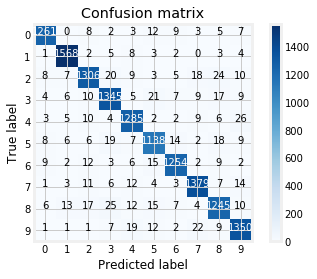

In [34]:
misLabeled = (y_test != dtc_cv_pred).sum()/X_test.shape[0]
dtcCvAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != dtc_cv_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_test != dtc_cv_pred).sum()/X_test.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{dtcCvAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(dtcCvAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,dtc_cv_pred, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

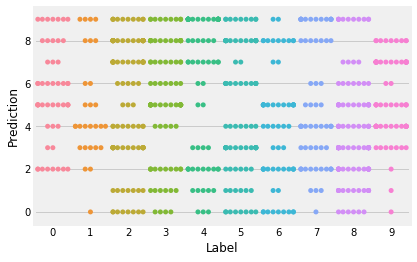

In [52]:
sns.swarmplot(x='Label',y='Prediction',data=missClassified_DTCV);

In [35]:
modelsPerformance

{'Name': ['dtc', 'dtc_cv'],
 'TestAccuracyScore': [0.8448051948051948, 0.8436598015768713],
 'PredictAccuracyScore': [0.8448051948051948, 0.9474025974025974],
 'FitTime': [10.152260599999998, 9.689056634902954],
 'ScoreTime': [0.07575149999999553, 0.12591314315795898],
 'PredictTime': [0.061106299999998726, 0.05599370000000192]}

### 2.2.3 Tune Model Performance
Tips:  
* Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand to give your tree a better chance of finding features that are discriminative.  
* Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant.  
* All decision trees use np.float32 arrays internally.  
* If the input matrix X is very sparse, it is recommended to convert to sparse csc_matrix before calling fit and sparse csr_matrix before calling predict. Training time can be orders of magnitude faster for a sparse matrix input compared to a dense matrix when features have zero values in most of the samples.   

In [36]:
# tune model

## 2.3 Model - RandomForestClassifier
Python Package: scikit-learn v0.21.3 [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).  

### 2.3.1 Create Models - RandomForestClassifier
Cross-Validate at 3 folds...

In [37]:
# pre-process datasets

#### Random Forest
attributes dtype as int64: build time = 20.5 s  
attributes dtype as int8: build time = 21.27 s  
attributes dtype as int16: build time = 20.18 s  

In [38]:
# MODEL BUILD - RANDOM FORESTS
forest = RandomForestClassifier(n_estimators = 100)
t = 0.0
with elapsed_timer() as elapsed:
    # fit the forest to the training data
    forest.fit(X_train, y_train)
    t = elapsed()
    if sh_logger.debug: print(f'RF Model Build Time: [{t}]')

modelsPerformance['Name'].append('forest')
modelsPerformance['FitTime'].append(t)

RF Model Build Time: [21.031507999999974]


attributes dtype as int64: fit score = 0.962  
attributes dtype as int8: fit score = 0.946  
attributes dtype as int16: fit score = 0.962  

In [39]:
# Model Output to kaggel training dataset split into training/testing
t = 0.0
forest_score = 0.0

with elapsed_timer() as elapsed:
    forest_score = forest.score(X_test, y_test)
    t = elapsed()
    if sh_logger.info: print(f'RF Fit Score: [{forest_score}]')
    if sh_logger.info: print(f'RF Score Time: [{t}]')
        
modelsPerformance['ScoreTime'].append(t)
modelsPerformance['TestAccuracyScore'].append(forest_score)

RF Fit Score: [0.9630591630591631]
RF Score Time: [0.8540760999999861]


In [40]:
#forest.get_params()
#forest.feature_importances_
#forest.n_features_
#forest.n_outputs_
#forest.n_classes_
modelsPerformance

{'Name': ['dtc', 'dtc_cv', 'forest'],
 'TestAccuracyScore': [0.8448051948051948,
  0.8436598015768713,
  0.9630591630591631],
 'PredictAccuracyScore': [0.8448051948051948, 0.9474025974025974],
 'FitTime': [10.152260599999998, 9.689056634902954, 21.031507999999974],
 'ScoreTime': [0.07575149999999553, 0.12591314315795898, 0.8540760999999861],
 'PredictTime': [0.061106299999998726, 0.05599370000000192]}

### 2.2.2 Fit Model Prediction

In [41]:
%%time
# predictions of test set split from training set
t = 0.0
with elapsed_timer() as elapsed:
    forest_pred = forest.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'RF Model Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

RF Model Predict Time: [0.7923541000000114]
Wall time: 786 ms


### 2.2.3 Evaluate Models

In [42]:
%%time
if sh_logger.debug: print(f'y_test size: {y_test.size} forest_pred size: {forest_pred.size}')

d = {'Label':y_test, 'Prediction':forest_pred}
forestPredictionsDf = pd.DataFrame(data=d)
if sh_logger.debug: print(f'Forest Predictions DF Shape: {forestPredictionsDf.shape}\n Head:\n{forestPredictionsDf.head()}')

# which test observations were miss classified
missClassified_RF = forestPredictionsDf[(forestPredictionsDf['Label'] != forestPredictionsDf['Prediction'])]

if sh_logger.debug: print(f'Miss Classified DF Shape: {missClassified_RF.shape}')
if sh_logger.debug: print(f'Miss Classified Percent: {missClassified_RF.shape[0]/y_test.size}')
if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != forest_pred).sum()}]')

y_test size: 13860 forest_pred size: 13860
Forest Predictions DF Shape: (13860, 2)
 Head:
   Label  Prediction
0      7           7
1      4           4
2      5           5
3      5           5
4      1           1
Miss Classified DF Shape: (512, 2)
Miss Classified Percent: 0.03694083694083694
Total Number of points: [13860]  Mislabeled Points: [512]
Wall time: 4.99 ms


Total Number of points: [13860]  Mislabeled Points: [512]
Percent Mislabeled: [0.03694083694083694]
Percent Accurately Labeled: [0.9630591630591631]


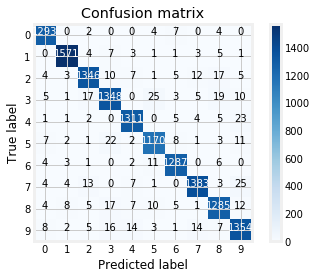

In [43]:
misLabeled = (y_test != forest_pred).sum()/X_test.shape[0]
forestAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != forest_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_test != forest_pred).sum()/X_test.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{forestAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(forestAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,forest_pred, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

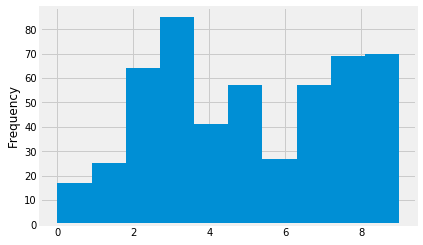

In [44]:
ax = missClassified_RF['Label'].plot.hist(bins=10)

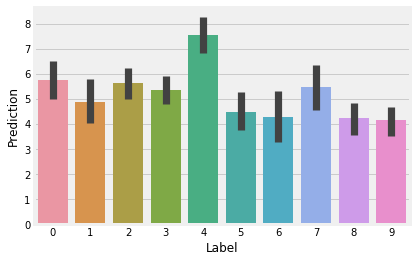

In [45]:
sns.barplot(x='Label',y='Prediction',data=missClassified_RF);

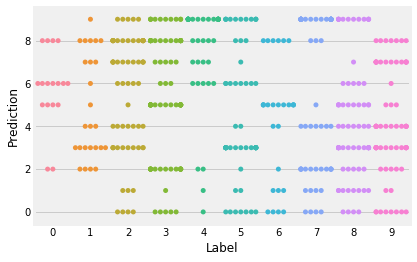

In [46]:
sns.swarmplot(x='Label',y='Prediction',data=missClassified_RF);

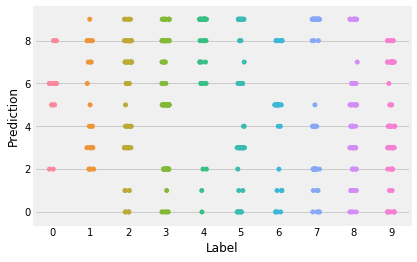

In [47]:
sns.stripplot(x='Label',y='Prediction',data=missClassified_RF);

In [48]:
%%time
# predictions of unseen test set for submission
t = 0.0
with elapsed_timer() as elapsed:
    forest_submit_pred = forest.predict(X_sub)
    t = elapsed()
    if sh_logger.debug: print(f'RF Model Predict Time: [{t}]')

RF Model Predict Time: [1.3733894999998029]
Wall time: 1.37 s


In [49]:
if sh_logger.debug: print(f'Random Forest Classification Submission Test size: {forest_submit_pred.size}')
    
#sPred = pd.DataFrame(X_sub)
#sub_predictions[1:40]
sample_sub['Label'] = forest_submit_pred
sample_sub.to_csv(f'{outputDir}rf_submission.csv', index=False)
sample_sub.head(10)

Random Forest Classification Submission Test size: 28000


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


### 2.2.4 Tune Models

In [55]:
# perform model creation and validation techniques

### 2.2.5 iNterpret Models
Interpret the model results, make knowledge based recommendations

In [56]:
# perform interpretation steps

# 3. Naive Bayes
**-------------------------------------------------------------------------------------------------**  
Python Package: SciKit-Learn [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)  
*Build a naïve Bayes model. Tune the parameters, such as the discretization options, to compare results.*  

## 3.1 Data Analysis
Clean and perform initial transformations steps of the data

### 3.1.1 Data Preprocessing (Scrubbing & Cleaning)

In [57]:
# create copy of training data to work on for model tuning with Cross-Validation
data = np.copy(X)
target = np.copy(y)

### 3.1.2 Explore
Explore the datasets

In [58]:
if sh_logger.debug: print(f'{data.shape} {target.shape}')
if sh_logger.debug: print(f'{data[1:10]} \n{target[1:10]}')

(42000, 784) (42000,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
[0 1 4 0 0 7 3 5 3]


## 3.2 Model
Create models
Creating a Naive Bayes model using [SciKit-Learn Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) package.  


### 3.2.1 Create Base Model
no cross-validation folds - using train/test split method

In [59]:
modelsPerformance

{'Name': ['dtc', 'dtc_cv', 'forest'],
 'TestAccuracyScore': [0.8448051948051948,
  0.8436598015768713,
  0.9630591630591631],
 'PredictAccuracyScore': [0.8448051948051948,
  0.9474025974025974,
  0.9630591630591631],
 'FitTime': [10.152260599999998, 9.689056634902954, 21.031507999999974],
 'ScoreTime': [0.07575149999999553, 0.12591314315795898, 0.8540760999999861],
 'PredictTime': [0.061106299999998726,
  0.05599370000000192,
  0.7923541000000114]}

In [60]:
# MODEL BUILD - Naive Bayes
gnb = GaussianNB()
t = 0.0
with elapsed_timer() as elapsed:
    # fit the GNB to the training data
    gnb.fit(X_train, y_train)
    t = elapsed()
    if sh_logger.debug: print(f'GNB Model Build Time: [{t}]')

modelsPerformance['Name'].append('gnb')
modelsPerformance['FitTime'].append(t)

GNB Model Build Time: [0.5441634999997405]


In [61]:
# Model Output to kaggel training dataset split into training/testing
t = 0.0
gnb_score = 0.0
with elapsed_timer() as elapsed:
    gnb_score = gnb.score(X_test, y_test)
    t = elapsed()
    if sh_logger.info: print(f'GNB Fit Score: [{gnb_score}]')
    if sh_logger.info: print(f'GNB Score Time: [{t}]')

modelsPerformance['TestAccuracyScore'].append(gnb_score)
modelsPerformance['ScoreTime'].append(t)

GNB Fit Score: [0.5525974025974026]


### 3.2.1.1 Predict Fit Models

In [62]:
%%time
# predictions of test set split from training set
t = 0.0
with elapsed_timer() as elapsed:
    gnb_pred = gnb.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'GNB Model Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

GNB Model Predict Time: [1.7562552999997934]
Wall time: 1.75 s


### 3.2.1.2 Evaluate Models

Total Number of points: [13860]  Mislabeled Points: [6201]
Percent Mislabeled: [0.4474025974025974]
Percent Accurately Labeled: [0.5525974025974025]


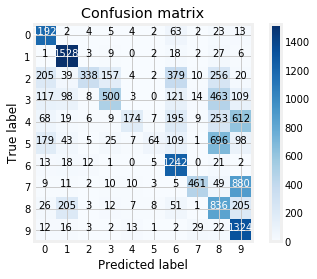

In [63]:
misLabeled = (y_test != gnb_pred).sum()/X_test.shape[0]
nbAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != gnb_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_test != gnb_pred).sum()/X_test.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{nbAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(nbAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,gnb_pred, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

## 3.2.2 Complement Naive Bayes
The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.  

### 3.2.2.1 Create Model

In [65]:
# MODEL BUILD - Complement Naive Bayes
#The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. 
#It is particularly suited for imbalanced data sets.

from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
t = 0.0
with elapsed_timer() as elapsed:
    # fit the CNB to the training data
    cnb.fit(X_train, y_train)
    t = elapsed()
    if sh_logger.debug: print(f'CNB Model Build Time: [{t}]')

modelsPerformance['Name'].append('cnb')
modelsPerformance['FitTime'].append(t)

CNB Model Build Time: [0.19264289999955508]


In [66]:
# Model Output to kaggel training dataset split into training/testing
t = 0.0
cnb_score = 0.0
with elapsed_timer() as elapsed:
    cnb_score = cnb.score(X_test, y_test)
    t = elapsed()
    if sh_logger.info: print(f'CNB Fit Score: [{cnb_score}]')


modelsPerformance['TestAccuracyScore'].append(cnb_score)
modelsPerformance['ScoreTime'].append(t)

CNB Fit Score: [0.714935064935065]


### 3.2.2.2 Predict Model

In [67]:
%%time
# predictions of test set split from training set
t = 0.0
with elapsed_timer() as elapsed:
    cnb_pred = cnb.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'CNB Model Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

CNB Model Predict Time: [0.07670239999970363]
Wall time: 78.1 ms


### 3.2.2.3 Evaluate Model

Total Number of points: [13860]  Mislabeled Points: [3951]
Percent Mislabeled: [0.2850649350649351]
Percent Accurately Labeled: [0.714935064935065]


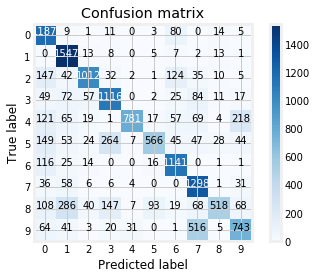

In [68]:
misLabeled = (y_test != cnb_pred).sum()/X_test.shape[0]
cnbAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != cnb_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_test != cnb_pred).sum()/X_test.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{cnbAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(cnbAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,cnb_pred, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

### 3.2.4 Tune Models

#### 3.2.4.1 Create Model using Cross-Validation

In [69]:
modelsPerformance

{'Name': ['dtc', 'dtc_cv', 'forest', 'gnb', 'cnb'],
 'TestAccuracyScore': [0.8448051948051948,
  0.8436598015768713,
  0.9630591630591631,
  0.5525974025974026,
  0.714935064935065],
 'PredictAccuracyScore': [0.8448051948051948,
  0.9474025974025974,
  0.9630591630591631,
  0.5525974025974025,
  0.714935064935065],
 'FitTime': [10.152260599999998,
  9.689056634902954,
  21.031507999999974,
  0.5441634999997405,
  0.19264289999955508],
 'ScoreTime': [0.07575149999999553,
  0.12591314315795898,
  0.8540760999999861,
  1.8223778000001403,
  0.07912320000104955],
 'PredictTime': [0.061106299999998726,
  0.05599370000000192,
  0.7923541000000114,
  1.7562552999997934,
  0.07670239999970363]}

In [70]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn import metrics
gnb_cv = GaussianNB()
cv = 3
gnb_cv_scores = cross_val_score(gnb_cv, data, target, cv=cv, scoring='f1_macro')
gnb_cv_scores

Wall time: 8.22 s


array([0.51548555, 0.5060259 , 0.51047707])

In [71]:
%%time
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
cv = 3
scoring = ['precision_macro', 'recall_macro']
gnb_cv2 = GaussianNB()
gnb_cv2_scores = cross_validate(gnb_cv2, data, target, scoring=scoring, cv=cv, 
                                return_train_score=True, return_estimator=True)


Wall time: 34.4 s


In [72]:
# output model results
if sh_logger.debug: print(f'Scorer Names: {sorted(gnb_cv2_scores.keys())}')
if sh_logger.info: print(f'Fit Time:               {gnb_cv2_scores["fit_time"]}')
if sh_logger.info: print(f'Score Time:             {gnb_cv2_scores["score_time"]}')
if sh_logger.info: print(f'Test Recall Scores:     {gnb_cv2_scores["test_recall_macro"]}')
if sh_logger.info: print(f'Test Precision Scores:  {gnb_cv2_scores["test_precision_macro"]}')
if sh_logger.info: print(f'Train Recall Scores:    {gnb_cv2_scores["train_recall_macro"]}')
if sh_logger.info: print(f'Train Precision Scores: {gnb_cv2_scores["train_precision_macro"]}')


Scorer Names: ['estimator', 'fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'train_precision_macro', 'train_recall_macro']
Fit Time:               [0.90220666 0.80869913 0.8218224 ]
Score Time:             [3.50194836 3.44823194 4.44742441]
Test Recall Scores:     [0.55655069 0.54957274 0.55724842]
Test Precision Scores:  [0.6740292  0.66896641 0.66588789]
Train Recall Scores:    [0.56147661 0.54797522 0.56196516]
Train Precision Scores: [0.68486952 0.67642211 0.67696248]


#### 3.2.4.2 Model Prediction

In [73]:
#%%time
# predictions of test set split from training set
bestFit = gnb_cv2_scores["test_precision_macro"].argmax()
gnb_cv_est = gnb_cv2_scores['estimator'][bestFit]
t = 0.0
with elapsed_timer() as elapsed:
    gnb_cv_pred = gnb_cv_est.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'Naive Bayes with CV Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)
modelsPerformance['Name'].append('gnb_cv')
modelsPerformance['FitTime'].append(gnb_cv2_scores["fit_time"][bestFit])
modelsPerformance['ScoreTime'].append(gnb_cv2_scores["score_time"][bestFit])
modelsPerformance['TestAccuracyScore'].append(gnb_cv2_scores["test_precision_macro"][bestFit])

Naive Bayes with CV Predict Time: [1.651511299998674]


#### 3.2.4.3 Model Evaluation

Total Number of points: [13860]  Mislabeled Points: [5947]
Percent Mislabeled: [0.42907647907647906]
Percent Accurately Labeled: [0.5709235209235209]


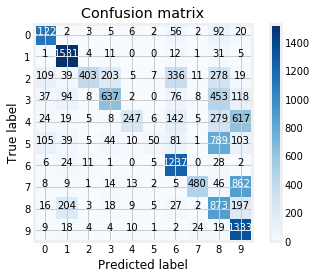

In [74]:
misLabeled = (y_test != gnb_cv_pred).sum()/X_test.shape[0]
nbCVAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != gnb_cv_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_test != gnb_cv_pred).sum()/X_test.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{nbCVAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(nbCVAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,gnb_cv_pred, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

### 3.3.5 Complement Naive Bayes with CV

In [77]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn import metrics
cnb_cv = ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cv = 3
cnb_cv_scores = cross_val_score(cnb_cv, data, target, cv=cv, scoring='f1_macro')
cnb_cv_scores

Wall time: 1.84 s


array([0.70366925, 0.70145871, 0.69565951])

In [79]:
%%time
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
cv = 3
scoring = ['precision_macro', 'recall_macro']
cnb_cv2 = ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cnb_cv2_scores = cross_validate(cnb_cv2, data, target, scoring=scoring, cv=cv, 
                                return_train_score=True, return_estimator=True)

Wall time: 2.83 s


In [80]:
# output model results
if sh_logger.debug: print(f'Scorer Names: {sorted(cnb_cv2_scores.keys())}')
if sh_logger.info: print(f'Fit Time:               {cnb_cv2_scores["fit_time"]}')
if sh_logger.info: print(f'Score Time:             {cnb_cv2_scores["score_time"]}')
if sh_logger.info: print(f'Test Recall Scores:     {cnb_cv2_scores["test_recall_macro"]}')
if sh_logger.info: print(f'Test Precision Scores:  {cnb_cv2_scores["test_precision_macro"]}')
if sh_logger.info: print(f'Train Recall Scores:    {cnb_cv2_scores["train_recall_macro"]}')
if sh_logger.info: print(f'Train Precision Scores: {cnb_cv2_scores["train_precision_macro"]}')

Scorer Names: ['estimator', 'fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'train_precision_macro', 'train_recall_macro']
Fit Time:               [0.48953247 0.48158693 0.45195508]
Score Time:             [0.14111781 0.14356256 0.15300584]
Test Recall Scores:     [0.71036493 0.70859042 0.70432896]
Test Precision Scores:  [0.75009572 0.74860591 0.74579701]
Train Recall Scores:    [0.70791525 0.70864266 0.71128889]
Train Precision Scores: [0.74913705 0.75059161 0.75032785]


### Model Prediction

In [81]:
#%%time
# predictions of test set split from training set
bestFit = cnb_cv2_scores["test_precision_macro"].argmax()
cnb_cv_est = cnb_cv2_scores['estimator'][bestFit]
t = 0.0
with elapsed_timer() as elapsed:
    cnb_cv_pred = cnb_cv_est.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'Component Naive Bayes with CV Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)
modelsPerformance['Name'].append('cnb_cv')
modelsPerformance['FitTime'].append(cnb_cv2_scores["fit_time"][bestFit])
modelsPerformance['ScoreTime'].append(cnb_cv2_scores["score_time"][bestFit])
modelsPerformance['TestAccuracyScore'].append(cnb_cv2_scores["test_precision_macro"][bestFit])

Component Naive Bayes with CV Predict Time: [0.08291240000107791]


### Model Evaluation

Total Number of points: [13860]  Mislabeled Points: [3922]
Percent Mislabeled: [0.282972582972583]
Percent Accurately Labeled: [0.717027417027417]


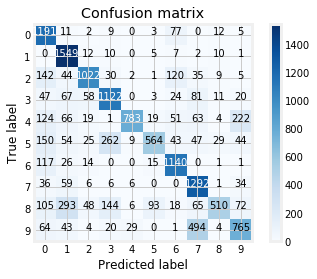

In [82]:
misLabeled = (y_test != cnb_cv_pred).sum()/X_test.shape[0]
cnbCVAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != cnb_cv_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_test != cnb_cv_pred).sum()/X_test.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{cnbCVAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(cnbCVAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,cnb_cv_pred, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

# 4. Algorithm Performance Comparison
**-------------------------------------------------------------------------------------------------**  
*Compare the results from the two algorithms. Which one reached higher accuracy? Which one runs faster? Can you explain why?*

In [86]:
# model accuracy of predicting labels, and compute time for mode build, score, predict
modelsPerf = pd.DataFrame(modelsPerformance)
modelsPerf.sort_values(by='PredictAccuracyScore', ascending=False)

,Name,TestAccuracyScore,PredictAccuracyScore,FitTime,ScoreTime,PredictTime
2,forest,0.963059,0.963059,21.031508,0.854076,0.792354
1,dtc_cv,0.843660,0.947403,9.689057,0.125913,0.055994
0,dtc,0.844805,0.844805,10.152261,0.075751,0.061106
6,cnb_cv,0.750096,0.717027,0.489532,0.141118,0.082912
4,cnb,0.714935,0.714935,0.192643,0.079123,0.076702
5,gnb_cv,0.674029,0.570924,0.902207,3.501948,1.651511
3,gnb,0.552597,0.552597,0.544163,1.822378,1.756255


In [88]:
modelsPerf.sort_values(by=['FitTime','ScoreTime','PredictTime'], ascending=True)

,Name,TestAccuracyScore,PredictAccuracyScore,FitTime,ScoreTime,PredictTime
4,cnb,0.714935,0.714935,0.192643,0.079123,0.076702
6,cnb_cv,0.750096,0.717027,0.489532,0.141118,0.082912
3,gnb,0.552597,0.552597,0.544163,1.822378,1.756255
5,gnb_cv,0.674029,0.570924,0.902207,3.501948,1.651511
1,dtc_cv,0.843660,0.947403,9.689057,0.125913,0.055994
0,dtc,0.844805,0.844805,10.152261,0.075751,0.061106
2,forest,0.963059,0.963059,21.031508,0.854076,0.792354


# 5. Kaggle Test Results
**-------------------------------------------------------------------------------------------------**
### 5.1 Submission File Format
The submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit predicted. For example, if predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then the submission file would look like:  

ImageId,Label  
1,3  
2,7  
3,8   
(27997 more lines)  

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that, all but 3% of the images have been correctly classified.  


In [84]:
if sh_logger.debug: print(f'Random Forest Classification Submission Test size: {forest_submit_pred.size}')
    
#sPred = pd.DataFrame(X_sub)
#sub_predictions[1:40]
sample_sub['Label'] = forest_submit_pred
sample_sub.to_csv(f'{outputDir}rf_submission.csv', index=False)
sample_sub.head(10)

Random Forest Classification Submission Test size: 28000


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
